In [63]:
import pandas as pd
import urllib.request
import numpy as np
import matplotlib as plt
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [288]:
print('Loading merged data ...')
mutations_raw = pd.read_csv("pancancer_mutations_merged.csv", 
                        usecols=['cancer_type', 'bcr_patient_barcode', 'Hugo_Symbol', 'BIOTYPE'])
print("done.")
print("Mutations count", mutations['bcr_patient_barcode'].count())

Loading merged data ...
done.
Mutations count 3570876


In [289]:
mutations_raw.head()

,Hugo_Symbol,BIOTYPE,cancer_type,bcr_patient_barcode
0,TACC2,protein_coding,GBM,TCGA-02-0003
1,JAKMIP3,protein_coding,GBM,TCGA-02-0003
2,PANX3,protein_coding,GBM,TCGA-02-0003
3,SPI1,protein_coding,GBM,TCGA-02-0003
4,NAALAD2,protein_coding,GBM,TCGA-02-0003


In [290]:
mutations = mutations_raw[mutations_raw['BIOTYPE'] == 'protein_coding']
mutations_non_coding_genes = mutations_raw[mutations_raw['BIOTYPE'] != 'protein_coding']

coding_genes = list(mutations['Hugo_Symbol'].unique())
non_coding_genes = list(mutations_non_coding_genes['Hugo_Symbol'].unique())
print("Number of coding genes:", len(coding_genes))
print("Number of non-coding genes:", len(non_coding_genes))
                                  



Number of coding genes: 19209
Number of non-coding genes: 2140



Number of cancer types 32
['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'OV' 'PAAD' 'PCPG'
 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC' 'UCS'
 'UVM']

Number of patients 10008


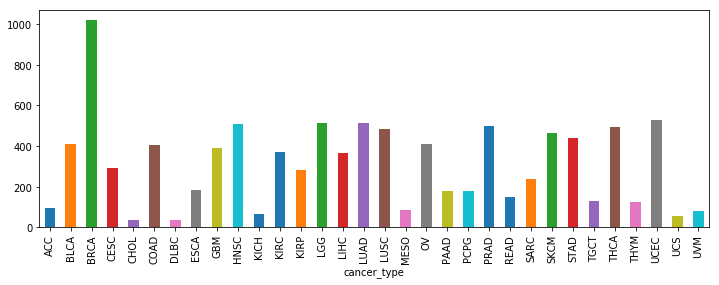

In [291]:
# Print out the number of cancer types that are present in the 
# mutations dataset
cancer_types = mutations['cancer_type'].unique()
print("\nNumber of cancer types", len(cancer_types))
print(np.sort(cancer_types))



# Get number of cases per cancer type
group_patients_by_cancer = mutations.groupby(['cancer_type'])['bcr_patient_barcode'].nunique()
print("\nNumber of patients", group_patients_by_cancer.sum())
group_patients_by_cancer.plot.bar(figsize=(12,4))

Mean number of genes represented for each cancer type: 11831
Min number of genes represented for each cancer type: 1606
Max number of genes represented for each cancer type: 19090


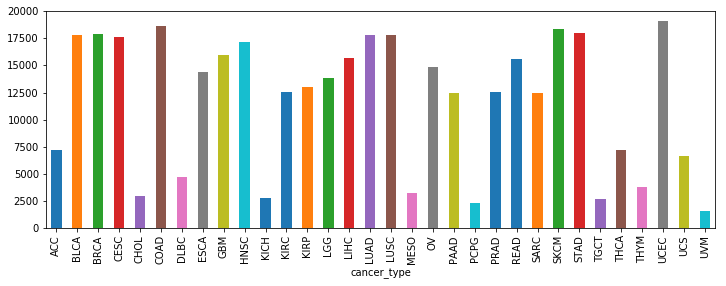

In [292]:
# Get the unique genes per cancer type
group_genes_by_cancer = mutations.groupby(['cancer_type'])['Hugo_Symbol'].nunique();
group_genes_by_cancer.plot.bar(figsize=(12,4))
print("Mean number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.mean())))
print("Min number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.min())))
print("Max number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.max())))

In [350]:
top_n_genes = 500

# Now try to find the most common genes per cancer type and
# merge these together to come up with a master list
cancer_gene_count = mutations.groupby(['cancer_type', 'Hugo_Symbol'])['bcr_patient_barcode'].nunique().reset_index(name='count')
cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']



# Now create a large matrix, row is the gene, column for each cancer type
df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                     columns=['cancer_type'], aggfunc=np.sum, fill_value=0)


# Now find the top n genes for each cancer type
top_genes = []
for cancer_type in gene_cancer_matrix.columns:
    sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
    top_rows = sorted_genes[sorted_genes > 0].head(top_n_genes)
    for gene, patient_count in top_rows.items():
        top_genes.append(list([cancer_type, gene, patient_count]))
            

# Turn this back into a matrix, row is gene, column for each cancer type
top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                     columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
top_gene_cancer_matrix.head()
print(top_gene_cancer_matrix.shape)



    
    

cancer_type,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
gene,,,,,,,,,,,,,,,,,,,,,
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,10,0,0,38,0,0,0,0,0,0
A2ML1,0,0,0,0,0,44,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AADACL4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
AASS,0,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0


(4778, 32)


Genes by patient frequency
  mean: 141
  min:  1
  max:  3879


,gene,patient_count
17222,TP53,3879
17606,TTN,3781
10315,MUC16,2415
3983,CSMD3,1610
14415,RYR2,1594
16203,SYNE1,1538
9210,LRP1B,1514
12362,PIK3CA,1428
6089,FLG,1399
17924,USH2A,1378


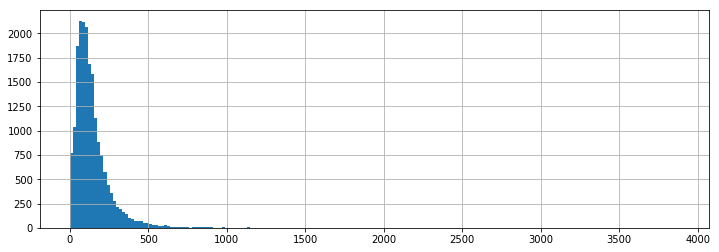

In [351]:
# Now try to find the most common genes across all cancer types
gene_count = mutations.groupby(['Hugo_Symbol'])['bcr_patient_barcode'].nunique().reset_index(name='count')
gene_count.columns = ['gene', 'patient_count']
gene_count = gene_count.sort_values(['patient_count', 'gene'], ascending=[0,1])
print('Genes by patient frequency')
print("  mean:", int(gene_count['patient_count'].mean()))
print("  min: ", int(gene_count['patient_count'].min()))
print("  max: ", int(gene_count['patient_count'].max()))
gene_count.head(10)

gene_count['patient_count'].hist(bins=200, figsize=(12,4))


In [352]:
feature_genes = top_gene_cancer_matrix.index


In [353]:
# We need to get a list of unique genes for every case
cases = list()
grouped = mutations.groupby('bcr_patient_barcode')
i = int(0)

cols = ['case_id', 'cancer_type']
for gene in feature_genes:
    cols.append(gene)


for name, group in grouped:
    case = list()
    case.append(name)
    for cc in group.cancer_type.head(1):
        case.append(cc)

    for gene_flag  in feature_genes.isin(group.Hugo_Symbol.unique()):
        switch = 0
        if gene_flag == True:
            switch = 1
        case.append(switch)
    cases.append(case)
 

cases_df = pd.DataFrame(cases)
cases_df.columns = cols



In [354]:
print("Number of rows in full dataset", cases_df.case_id.count())

Number of rows in full dataset 10008


In [355]:
cases_df.shape
cases_df.head()


(10008, 4780)

,case_id,cancer_type,A1CF,A2M,A2ML1,AADACL4,AASS,ABCA1,ABCA12,ABCA13,...,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN29,ZSWIM8,ZW10,ZXDB,ZYG11B,ZYX,ZZEF1
0,TCGA-02-0003,GBM,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-02-0033,GBM,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-02-0047,GBM,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-02-0055,GBM,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-02-2466,GBM,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [356]:
# Write out transformed data to csv
print("Writing case feature matrix to csv ...")
cases_df.to_csv("pancancer_case_features.csv")
print("done.")

Writing case feature matrix to csv ...
done.
